<a href="https://colab.research.google.com/github/Rizwanali324/Deep_learning_images_Classification/blob/main/inception_V3_cloth_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**:Setupt the kaggle API**

In [ ]:
!pip install kaggle


### **Load the user kaggle api jsonfile **

In [ ]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
import os

# Create the Kaggle directory
!mkdir -p ~/.kaggle

# Move the Kaggle API key to the Kaggle directory
!mv kaggle.json ~/.kaggle/


In [ ]:
# Set permissions for the Kaggle API key file
!chmod 600 ~/.kaggle/kaggle.json


### Load the dataset from kaggle using api

In [ ]:
!kaggle datasets download -d sunnykusawa/cloth-dataset

 95% 9.00M/9.43M [00:01<00:00, 14.3MB/s]
100% 9.43M/9.43M [00:01<00:00, 9.44MB/s]


In [ ]:
# Step 5: Unzip the downloaded dataset
!unzip cloth-dataset.zip

Archive:  cloth-dataset.zip
  inflating: cloth_dataset/jeans/1.jpg  
  inflating: cloth_dataset/jeans/10.jpg  
  inflating: cloth_dataset/jeans/100.jpg  
  inflating: cloth_dataset/jeans/101.jpg  
  inflating: cloth_dataset/jeans/102.jpg  
  inflating: cloth_dataset/jeans/103.jpg  
  inflating: cloth_dataset/jeans/104.jpg  
  inflating: cloth_dataset/jeans/105.jpg  
  inflating: cloth_dataset/jeans/106.jpg  
  inflating: cloth_dataset/jeans/107.jpg  
  inflating: cloth_dataset/jeans/108.jpg  
  inflating: cloth_dataset/jeans/109.jpg  
  inflating: cloth_dataset/jeans/11.jpg  
  inflating: cloth_dataset/jeans/110.jpg  
  inflating: cloth_dataset/jeans/111.jpg  
  inflating: cloth_dataset/jeans/112.jpg  
  inflating: cloth_dataset/jeans/113.jpg  
  inflating: cloth_dataset/jeans/114.jpg  
  inflating: cloth_dataset/jeans/115.jpg  
  inflating: cloth_dataset/jeans/116.jpg  
  inflating: cloth_dataset/jeans/117.jpg  
  inflating: cloth_dataset/jeans/118.jpg  
  inflating: cloth_dataset/jea

## Load the data and make train and test dirs sprately

In [ ]:
import os
import shutil
import random

# Define the paths
data_dir = '/content/cloth_dataset'
train_dir = '/content/train'
test_dir = '/content/test'

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the percentage of data to use for training (80%)
train_percentage = 0.8

# Iterate through the subfolders (label classes)
for label_class in os.listdir(data_dir):
    label_class_path = os.path.join(data_dir, label_class)

    # Create subdirectories in train and test folders
    train_class_dir = os.path.join(train_dir, label_class)
    test_class_dir = os.path.join(test_dir, label_class)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # List all files in the current label class folder
    files = os.listdir(label_class_path)

    # Shuffle the files randomly
    random.shuffle(files)

    # Calculate the split index based on the train_percentage
    split_index = int(len(files) * train_percentage)

    # Split files into train and test sets
    train_files = files[:split_index]
    test_files = files[split_index:]

    # Copy train files to the train directory
    for file in train_files:
        src_path = os.path.join(label_class_path, file)
        dst_path = os.path.join(train_class_dir, file)
        shutil.copy(src_path, dst_path)

    # Copy test files to the test directory
    for file in test_files:
        src_path = os.path.join(label_class_path, file)
        dst_path = os.path.join(test_class_dir, file)
        shutil.copy(src_path, dst_path)

print("Data splitting complete.")


Data splitting complete.


## Display the train and test images with class labels

Random Images from Train Directory:


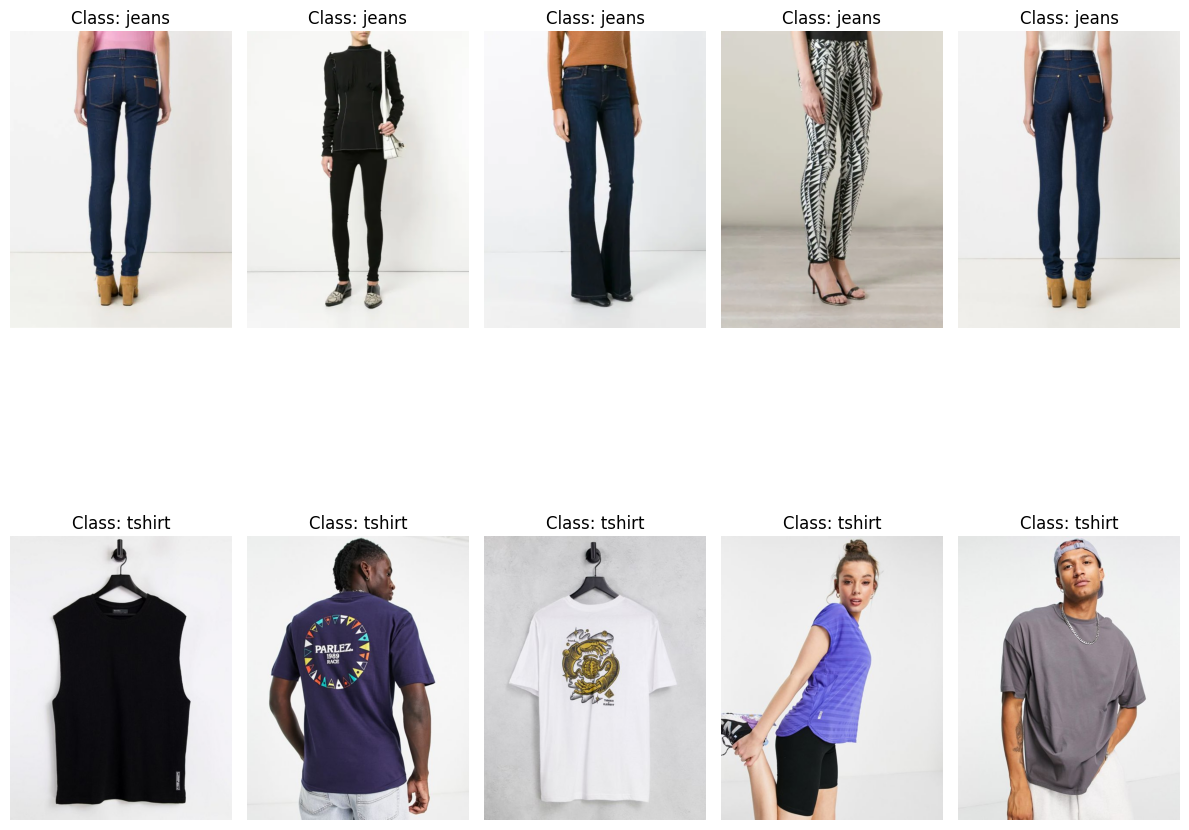

Random Images from Test Directory:


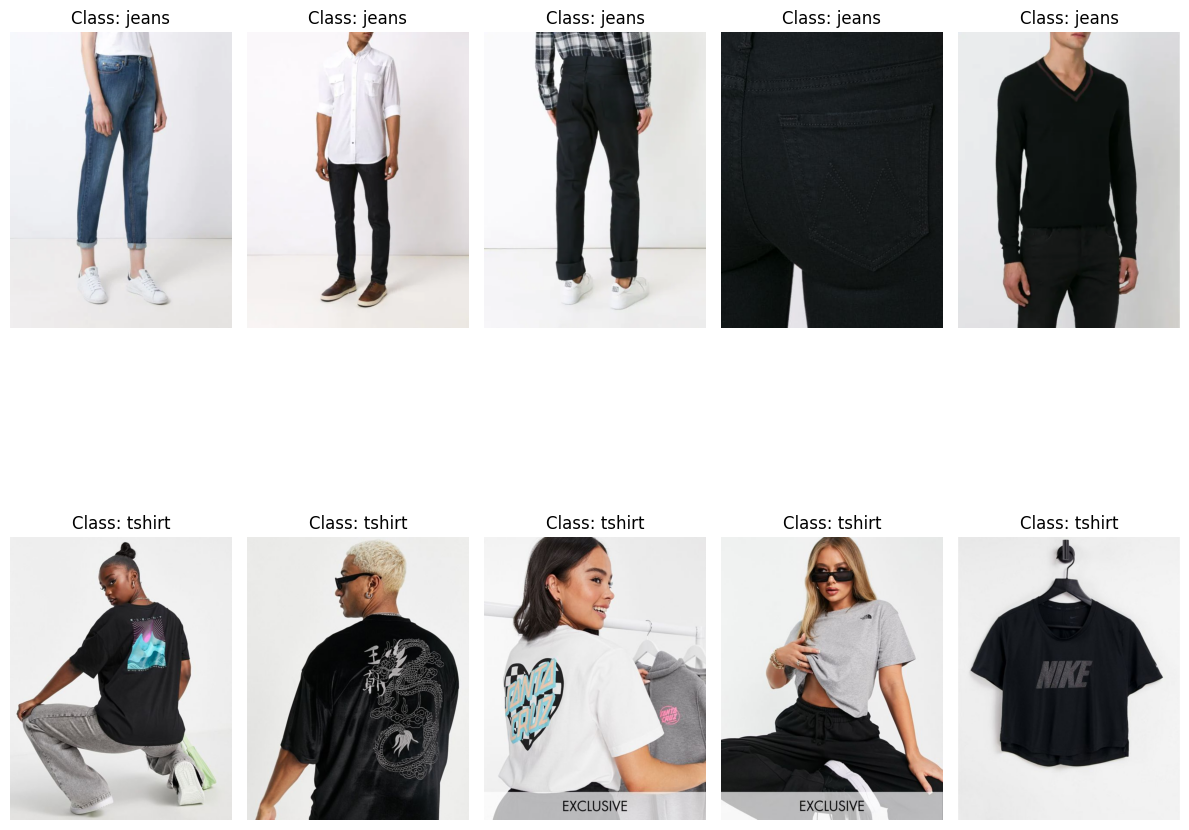

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the paths to the train and test directories
train_dir = '/content/train'
test_dir = '/content/test'

# Function to display random images from a directory in rows
def display_random_images_in_rows(directory):
    # Get a list of subdirectories (class labels)
    class_labels = os.listdir(directory)

    # Create a subplot with a number of rows based on the number of class labels
    num_rows = len(class_labels)
    fig, axes = plt.subplots(num_rows, 5, figsize=(12, 12))

    # Iterate through class labels and rows
    for i, label in enumerate(class_labels):
        class_dir = os.path.join(directory, label)
        # Get a list of image files in the class directory
        image_files = os.listdir(class_dir)

        # Randomly select 5 images
        random_images = random.sample(image_files, 5)

        # Display the selected images along with their class label in a row
        for j, image_file in enumerate(random_images):
            img_path = os.path.join(class_dir, image_file)
            img = mpimg.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'Class: {label}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Display random images from the train and test directories in rows
print("Random Images from Train Directory:")
display_random_images_in_rows(train_dir)

print("Random Images from Test Directory:")
display_random_images_in_rows(test_dir)


# Print the class label and number of images

In [ ]:
# Get a list of class labels (subdirectory names)
class_labels = os.listdir(data_dir)

# Iterate through class labels and count the number of images in each class
for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        # List all files in the class directory and count the images
        num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        print(f"Class: {label}, Number of Images: {num_images}")

Class: jeans, Number of Images: 199
Class: tshirt, Number of Images: 199


## Data augmentation and rescale the images

In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_height, img_width = 150, 150
batch_size = 32

# Create ImageDataGenerator instances for train and test data with augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Scale pixel values to [0, 1]
    rotation_range=40,          # Randomly rotate images
    width_shift_range=0.2,      # Randomly shift image width
    height_shift_range=0.2,     # Randomly shift image height
    shear_range=0.2,            # Shear intensity
    zoom_range=0.2,             # Zoom intensity
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill mode for new pixels after rotation or shifting
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for the test set

# Create data generators for train and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Assuming you have categorical labels
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Print the number of batches and samples in the train and test generators
print("Number of batches in train generator:", len(train_generator))
print("Number of samples in train generator:", len(train_generator.filenames))
print("Number of batches in test generator:", len(test_generator))
print("Number of samples in test generator:", len(test_generator.filenames))


Found 318 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Number of batches in train generator: 10
Number of samples in train generator: 318
Number of batches in test generator: 3
Number of samples in test generator: 80


## LOAD THE INCEPTION V3 MODELS WITHOUT FREEZING THE LAYERS

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy

# Define image dimensions
img_height, img_width = 150, 150
num_classes = len(os.listdir(train_dir))

# Create an instance of InceptionV3 with pre-trained weights (excluding top layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=[CategoricalAccuracy()])

# Define the number of training and testing steps per epoch
train_steps_per_epoch = len(train_generator)
test_steps_per_epoch = len(test_generator)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


87910968/87910968 [==============================] - 5s 0us/step


Epoch 1/10
10/10 [==============================] - 60s 924ms/step - loss: 0.8605 - categorical_accuracy: 0.7893 - val_loss: 11.7563 - val_categorical_accuracy: 0.6375
Epoch 2/10
10/10 [==============================] - 3s 293ms/step - loss: 0.3643 - categorical_accuracy: 0.9214 - val_loss: 1.9834 - val_categorical_accuracy: 0.7875
Epoch 3/10
10/10 [==============================] - 3s 291ms/step - loss: 0.1009 - categorical_accuracy: 0.9623 - val_loss: 26.6692 - val_categorical_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 3s 346ms/step - loss: 0.0621 - categorical_accuracy: 0.9874 - val_loss: 32.8964 - val_categorical_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 3s 322ms/step - loss: 0.1427 - categorical_accuracy: 0.9591 - val_loss: 11.3229 - val_categorical_accuracy: 0.6875
Epoch 6/10
10/10 [==============================] - 3s 290ms/step - loss: 0.1013 - categorical_accuracy: 0.9686 - val_loss: 2.9319 - val_categorical_accuracy: 0.7875

## DISPLAY THE GRAPH AND CHECK THE MODEL PERFORMANCE

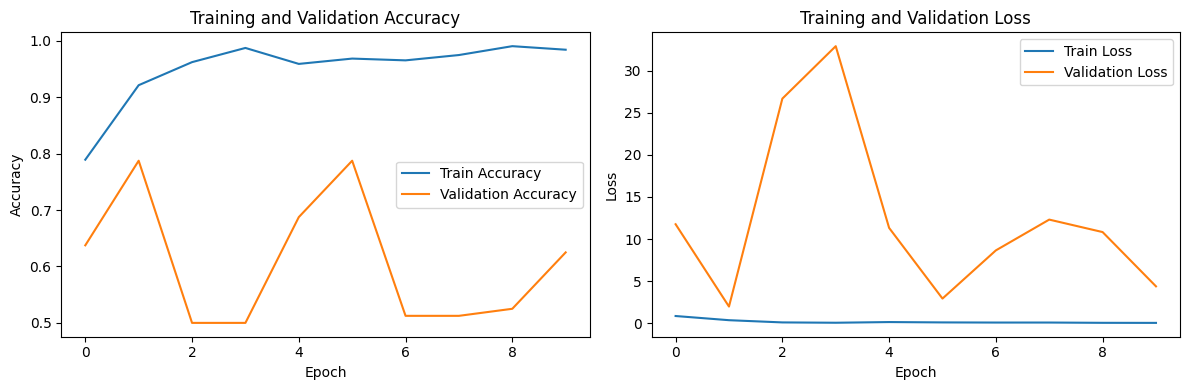

3/3 [==============================] - 1s 130ms/step - loss: 4.3828 - categorical_accuracy: 0.6250
Test Loss: 4.3828
Test Accuracy: 0.6250


In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

## LOAD THE MODEL WIHT FREEZING THE LAYERS AND CHECK THE PERFORMANCE OF MODEL

In [ ]:

# Define image dimensions
img_height, img_width = 150, 150
num_classes = len(os.listdir(train_dir))

# Create an instance of InceptionV3 with pre-trained weights (excluding top layers)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=[CategoricalAccuracy()])

# Define the number of training and testing steps per epoch
train_steps_per_epoch = len(train_generator)
test_steps_per_epoch = len(test_generator)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
10/10 [==============================] - 9s 478ms/step - loss: 3.8946 - categorical_accuracy: 0.6226 - val_loss: 0.5389 - val_categorical_accuracy: 0.8250
Epoch 2/10
10/10 [==============================] - 3s 276ms/step - loss: 0.3740 - categorical_accuracy: 0.8522 - val_loss: 0.1522 - val_categorical_accuracy: 0.9250
Epoch 3/10
10/10 [==============================] - 3s 310ms/step - loss: 0.1238 - categorical_accuracy: 0.9623 - val_loss: 0.0906 - val_categorical_accuracy: 0.9750
Epoch 4/10
10/10 [==============================] - 3s 278ms/step - loss: 0.0852 - categorical_accuracy: 0.9717 - val_loss: 0.0846 - val_categorical_accuracy: 0.9750
Epoch 5/10
10/10 [==============================] - 3s 273ms/step - loss: 0.0359 - categorical_accuracy: 0.9906 - val_loss: 0.0813 - val_categorical_accuracy: 0.9875
Epoch 6/10
10/10 [==============================] - 4s 392ms/step - loss: 0.0299 - categorical_accuracy: 0.9937 - val_loss: 0.0770 - val_categorical_accuracy: 0.9875
Epoc

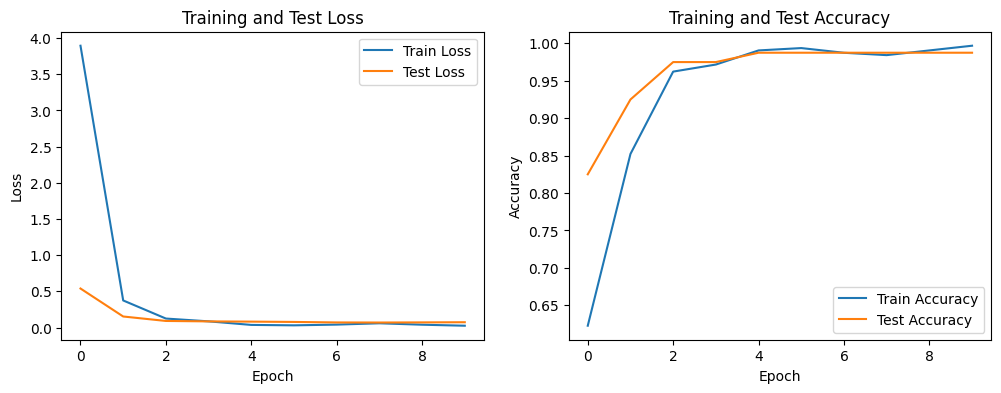

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')

plt.show()

## SAVE THE MODEL

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
train_accuracy = history.history['categorical_accuracy'][-1]  # Get the final training accuracy

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 0s 133ms/step - loss: 0.0730 - categorical_accuracy: 0.9875
Train Accuracy: 0.9969
Test Accuracy: 0.9875


## RELOAD THE MODEL AND TEST THE CLASSIFICATION IMAGES ON RANDOM IMAGES

In [ ]:
# Save the model to a file (in HDF5 format)
model.save('my_model.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('my_model.h5')


1/1 [==============================] - 0s 28ms/step


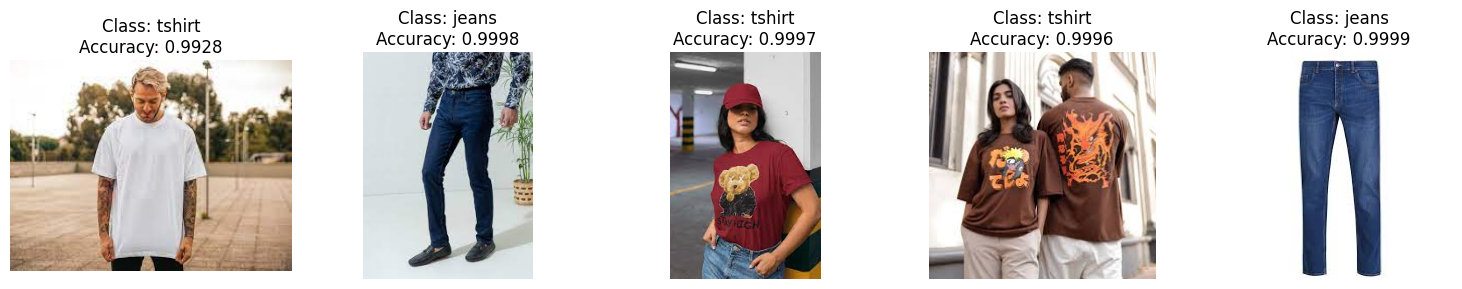

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
loaded_model = load_model('my_model.h5')  # Assuming you've already saved the model

# Define the path to the folder containing test images
test_images_dir = '/content/Test images'  # Replace with the actual path

# Define image dimensions
img_height, img_width = 150, 150

# Get a list of image files in the test directory
image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Initialize lists to store images, predicted classes, and accuracy scores
images = []
predicted_classes = []
accuracy_scores = []

# Loop through the test images and make predictions
for image_file in image_files:
    # Load and preprocess the image
    img_path = os.path.join(test_images_dir, image_file)
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = img / 255.0  # Normalize the image (if necessary)

    # Make predictions using the loaded model
    predictions = loaded_model.predict(np.expand_dims(img, axis=0))

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get the predicted class label using the actual class labels
    predicted_class_label = class_labels[predicted_class_index]

    # Get the accuracy score (probability) for the predicted class
    accuracy_score = predictions[0][predicted_class_index]

    # Append results to lists
    images.append(mpimg.imread(img_path))
    predicted_classes.append(predicted_class_label)
    accuracy_scores.append(accuracy_score)

# Define the number of images per row
images_per_row = 5

# Calculate the number of rows needed
num_images = len(image_files)
num_rows = (num_images + images_per_row - 1) // images_per_row

# Create subplots for displaying images in rows
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

# Loop through images and display in rows
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f"Class: {predicted_classes[i]}\nAccuracy: {accuracy_scores[i]:.4f}")
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots if there are fewer images than expected

plt.tight_layout()
plt.show()
